# Overview

This week's curriculum focuses in figuring out (and visualizing) what's special about a certain text (or collection of texts). We'll also learn about community detection in networks (that's how we'll get our groups of text)

* Tricks for raw text (NLPP, Chapter 3).
* Community Detection and info-boxes 
* Identifying important words in a document (TF-IDF)

In the first part, we will take a quick tour of NLPP1e's chapter 3, which is boring, but an amazing ressource that you'll keep returning to. Then we'll talk about how we can use simple statistics & machine learning to get text to show us what it's all about. We will even do a little visualization. 

In the latter parts we will go back to network science, discussing community detection, mixing in some NLP, and trying it all out on our very own dataset.


# Part 1: Processing real text (from out on the inter-webs)

Ok. So Chapter 3 in NLPP is all about working with text from the real world. Getting text from this internet, cleaning it, tokenizing, modifying (e.g. stemming, converting to lower case, etc) to get the text in shape to work with the NLTK tools you've already learned about - and many more. 

In the process we'll learn more about regular expressions, as well as unicode; something we've already been struggling with a little bit will now be explained in more detail. 
> 
> **Video lecture**: Short overview of chapter 3 + a few words about kinds of language processing that we don't address in this class. 
> 

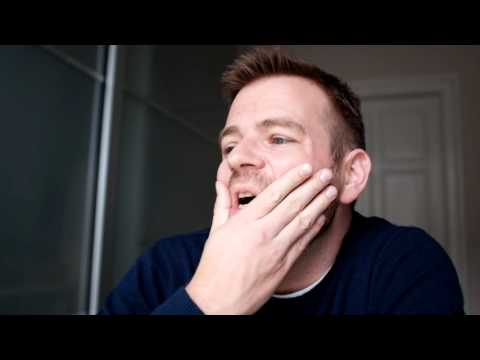

In [1]:
from IPython.display import YouTubeVideo
YouTubeVideo("Rwakh-HXPJk",width=800, height=450)

> *Reading*: NLPP Chapter 3.1, 3.2, 3.3, 3.4, 3.5, 3.6, 3.7, 3.9, and 3.10\. It's not important that you go in depth with everything here - the key think is that you *know that Chapter 3 of this book exists*, and that it's a great place to return to if you're ever in need of an explanation of regular expressions, unicode, or other topics that you forget as soon as you stop using them (and don't worry, I forget about those things too).
> 

In [2]:
import json
import urllib.request
import matplotlib.pyplot as plt
import re
import os
import networkx as nx
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict
import matplotlib.cm as cm
import numpy as np  
import community.community_louvain as community
from fa2_modified import ForceAtlas2
import pandas as pd
import nltk
import string
from nltk.corpus import wordnet
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.probability import FreqDist
from wordcloud import WordCloud
import math
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords
import igraph as ig
import random

In [3]:
# # acquire the singer names list
# def wikiinfo(title):
#     baseurl =  "https://en.wikipedia.org/w/api.php?"
#     action = "action=query"
#     title = urllib.parse.urlencode({'titles': title})
#     content = "prop=revisions&rvprop=content"
#     dataformat ="format=json"
#     query = "{}{}&{}&{}&{}".format(baseurl, action, content, title, dataformat)
#     wikiresponse = urllib.request.urlopen(query)
#     wikidata = wikiresponse.read()
#     wikitext = wikidata.decode('utf-8')
#     wikijson = json.loads(wikitext)
#     return wikijson
# wikijson = wikiinfo(title="List_of_country_music_performers")
# #the content include the singer names
# artist_content = wikijson['query']['pages']['328877']['revisions'][0]['*'] 
# #extract the singer names
# singer_names = re.findall(r'\*\[\[([^\|\(\]]+)', artist_content)
# #remove the duplicate names and sort the names 
# singer_names = sorted(set(singer_names)) 
# # Extract [[...]] from the content and clean by removing parentheses and text after '|'
# def get_connected_names(content):
#     matches = re.findall(r'\[\[(.*?)\]\]', content)
#     connected_names = [re.sub(r'\(.*?\)|\|.*', '', match).strip() for match in matches]
#     return connected_names

# # fliter the connected names that are in the singer_names list
# def filter_connected_names(connected_names, singer_names):
#     filtered_names = [name for name in connected_names if name in singer_names]
#     return filtered_names

# # Count the number of words in the content
# def count_words(content):
#     return len(re.findall(r'\b\w+\b', content))

# def get_connected_map(folder_path, singer_names):
#     # Create a undirected graph
#     G = nx.Graph()
#     folder_path = os.path.abspath(folder_path)
    
#     # Iterate through all the .txt files in the folder
#     for filename in os.listdir(folder_path):
#         if filename.endswith(".txt"):
#             file_path = os.path.join(folder_path, filename)
            
#             if os.path.exists(file_path):
                
#                 with open(file_path, 'r', encoding='utf-8') as file:
#                     content = file.read()
                
#                 # Use the file name as the node
#                 filename_m = os.path.splitext(filename)[0]
            
#                 # Check if the content is empty and set content_length accordingly
#                 content_length = count_words(content=content) if content.strip() else 0
                
#                 # Add the node with the content_length as an attribute
#                 G.add_node(filename_m, content_length=content_length)
                
#                 # Get and filter the connected names
#                 connected_names = get_connected_names(content)
#                 filtered_names = filter_connected_names(connected_names, singer_names)
                
#                 # Add edges for each filtered name
#                 for name in filtered_names:
#                     G.add_edge(filename_m, name)
#             else:
#                 print(f"File not found: {file_path}")

#     return G


# folder_path = 'wiki_pages'  
# G = get_connected_map(folder_path, singer_names)
# G.remove_edges_from(nx.selfloop_edges(G))  # remove self-loop edges
# # the bascial information of the graph
# print(f"Graph has {G.number_of_nodes()} \n nodes and {G.number_of_edges()} edges.")


# Part 2: Community detection

Before we get started on *network* communities, we'll grab some information on a different kind of communities based on information from Wikipedia. Specifically, the ``infoboxes``. An infobox is the little box usually displayed on the right when you open an artist's page. 

For example if you open the page for [Old 97's](https://en.wikipedia.org/wiki/Old_97%27s), you'll see that it contains info about their ***origin***, the ***genre***s of music they've been associated with, their ***year's active***, the record ***labels*** they've signed with, etc. All really interesting information if we want to understand the network of artists.

Today, we'll be playing with **genre**. It's not easy to extract information from the infoboxes, but one of your amazing TAs (Aliaksandr) has done the job for you already (he even parsed the html to get data for more artists).

> **You can download the genres [here](https://raw.githubusercontent.com/SocialComplexityLab/socialgraphs2024/refs/heads/main/files/artists_genres_dictionary.txt)**.



Now, let's watch a lecture to learn about communities. If you want all the details, I recommend you take a look at _Chapter 9_ in the _Network Science_ book ... but the video lecture below should be enough to get you started. 

**Note**: For this and the next exercise, work on the _undirected_ version of the network.

> **_Video Lecture_**: Communities in networks. 

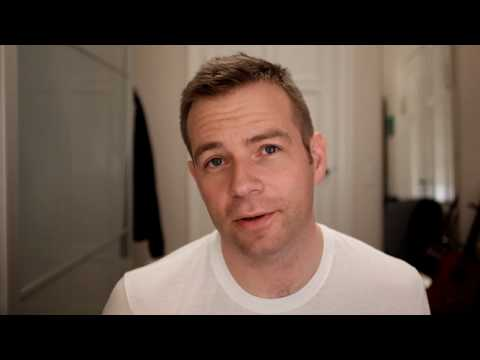

In [4]:
YouTubeVideo("FSRoqXw28RI",width=800, height=450)

*Exercise*: Use the concept of modularity to explore how _community-like_ the genres are.
> 
> * Explain the concept of modularity in your own words.
> * Work from the undirected version of the network, keeping only the nodes for which you have genre information in the file above. 
> * Now create your own partition of the network into genres.
>      * **Each node is simply characterized by the *first genre* in its list of genres**.
>      * Each community is the group of nodes that share the same genre.
>      * That's all you need, now calculate the modularity of this division of the network into genres.
>      * **Note**: Modularity is described in the _Network Science_ book, section 9.4.. Thus, use **equation 9.12** in the book to calculate the modularity _M_ of the partition described above. Are the genres good communities?
> * Spoiling your findings a little bit, an issue is the following: Almost all artists have the genre `country` as their first genre in the list, so by definition the network won't have very high modularity. What happens to the modularity if you grab the first genre *that's not `country`* as the genre-assignment for all nodes that have more than one genre? 

<div class="alert alert-block alert-info">
Overall, it's OK to use an LLM to help with the code here. But do write your own explanation of modularity, and do try to implement a modularity on your own from eq 9.12 in the book.
</div>

modularity is the metrics to evaluate the quality of the community partition which offer a novel way to community detection.

$M_c = \frac{1}{2L} \sum_{(i,j) \in C_c} (A_{ij} - p_{ij}) = \frac{L_c}{L}-(\frac{k_c}{2L})^2$

$M = \sum_{c} M_c = \sum^{(n_c)}_{c=1}\frac{L_c}{L}-(\frac{k_c}{2L})^2$
From the result we can see that the modularity raised from 0.071 to 0.081, split the big community 'country' into other small communities increase the modularity therefore it a better partition for the network.

In [5]:
#remove the node that not in geners
# Load singer data from 'genres.txt'

with open('artists_genres_dictionary.txt', 'r') as f:
    genres_data = json.load(f)

# Lets use wikipedia API to get the page of the artists
def get_wiki(title):
    baseurl = "https://en.wikipedia.org/w/api.php?"
    action = "action=query"
    content = "prop=revisions&rvprop=content"
    dataformat = "format=json"
    
    # URL-encode the title to handle spaces and special characters
    title = "titles={}".format(urllib.parse.quote(title))
    
    # Build the query URL
    query = "{}{}&{}&{}&{}".format(baseurl, action, content, title, dataformat)
    
    # Make the request to Wikipedia API
    wikiresponse = urllib.request.urlopen(query)
    wikidata = wikiresponse.read()
    
    # Decode and return the JSON data
    wikitext = wikidata.decode('utf-8')
    return json.loads(wikitext)

def extract_page_content(wiki_data):
    try:
        # Get the page key (pageid) dynamically (since page IDs can vary)
        page = list(wiki_data['query']['pages'].values())[0]
        return page['revisions'][0]['*']  # Return the raw page content
    except KeyError:
        return None  # In case there's no content found
    
# Function to format a valid filename from an artist name
def format_filename(artist_name):
    # Remove characters that are invalid for filenames on most systems
    return re.sub(r'[\\/*?:"<>|]', '', artist_name)
# Create a list of artist names
artist_names = list(genres_data.keys())

# Output directory for saving Wikipedia pages
output_dir = "wikipedia_pages"

# Loop through each artist, fetch their Wikipedia page, and save it
for artist in artist_names:
    # Format the filename and create the full path
    filename = format_filename(artist) + ".txt"
    file_path = os.path.join(output_dir, filename)

    # Check if the file already exists; if so, skip to the next artist
    if os.path.exists(file_path):
        continue

    # Query Wikipedia and retrieve page content if file does not exist
    wiki_data = get_wiki(artist)
    page_content = extract_page_content(wiki_data)
    
    if page_content:
        # Write the page content to a text file
        with open(file_path, 'w', encoding='utf-8') as f:
            f.write(page_content)
        print(f"Successfully saved Wikipedia page for {artist} to {file_path}") # Print success message if file is saved because the file did not exist
    else:
        print(f"Wikipedia page for {artist} does not exist or has no content.")

# Function to get the names of connected artists from the Wikipedia page content
def get_connected_names(content):
    # Find matches within [[...]]
    matches = re.findall(r'\[\[(.*?)\]\]', content)
    
    # Clean up each match to standardize the format
    connected_names = []
    for match in matches:
        # Remove text within parentheses and after '|'
        name = re.sub(r'\(.*?\)|\|.*', '', match).strip()
        connected_names.append(name)
    
    return connected_names

# Function to filter out non-artist names from the artist_names list
def filter_connected_names(connected_names, singer_names):
    filtered_names = [name for name in connected_names if name in singer_names]
    return filtered_names

# Function to count the number of words in a given content
def count_words(content):
    return len(re.findall(r'\b\w+\b', content))

# Function to create the graph
def create_map(folder_path, singer_names):
    # Convert folder path to absolute path
    folder_path = os.path.abspath(folder_path)
    
    # Initialize an undirected graph
    G = nx.Graph()

    for artist in singer_names:
        # Prepare file path
        artist_filename = format_filename(artist)
        file_path = os.path.join(folder_path, f"{artist_filename}.txt")

        # Skip if file does not exist
        if not os.path.exists(file_path):
            print(f"File not found: {file_path}")
            continue

        # Open and read content
        with open(file_path, 'r', encoding='utf-8') as file:
            content = file.read().strip()
        
        # Calculate content length if content is not empty
        content_length = count_words(content) if content else 0

        # Add artist as a node with content_length attribute
        G.add_node(artist, content_length=content_length)
        
        # Process and filter connected names for edge addition
        filtered_names = filter_connected_names(get_connected_names(content), singer_names)
        G.add_edges_from((artist, name) for name in filtered_names)
    
    return G


In [6]:
folder_path = 'wikipedia_pages'
# create Graph
G = create_map(folder_path, singer_names=artist_names)
#delete self loops
G.remove_edges_from(nx.selfloop_edges(G))

print(f'The number of nodes in G', G.number_of_nodes())
print(f'The number of edges in G', G.number_of_edges())

The number of nodes in G 1833
The number of edges in G 13467


In [7]:
#create the graph for the genres community question
G_genres = G
# assign each nodes as their first genre
node_genres = {}
for artist, genres in genres_data.items():
    node_genres[artist] = genres[0] if genres else 'unknown'
nx.set_node_attributes(G_genres, node_genres, 'genre')

# put the nodes into the corresponing communities
genre_communities = defaultdict(list)
for node, data in G_genres.nodes(data=True):
    genre = data.get('genre', 'unknown')
    genre_communities[genre].append(node)

# calculate the modularity
def calculate_modularity(G, communities):
    node_to_index = {node: idx for idx, node in enumerate(G.nodes())}
    A = nx.to_numpy_array(G, nodelist=G.nodes())  # adjacency matrix for whole network
    L = G.number_of_edges()
    degrees = dict(G.degree())
    modularity = 0.0

    for community in communities:
        indices = [node_to_index[node] for node in community] # indices of nodes in community
        subgraph = A[np.ix_(indices, indices)] # adjacency matrix for community
        ki = np.array([degrees[node] for node in community]) # degree of nodes in community

        # Sum over all pairs including i == j
        sum_Aij = np.sum(subgraph)
        sum_kikj = np.sum(np.outer(ki, ki)) / (2 * L)

        modularity += (sum_Aij - sum_kikj) # sum over all communities

    modularity /= (2 * L) # divide by 2L
    return modularity
    
M = calculate_modularity(G_genres, genre_communities.values())
print("modularity of the first genres(include contry):", M)

modularity of the first genres(include contry): 0.07098935918585711


In [8]:
#create the graph for the genres community question
G_genres_1 = G
# assign each nodes as their first genre, if the first genre is country, assign the second genre as the genre
node_genres = {}
for artist, genres in genres_data.items():
    if genres and genres[0] == 'country' and len(genres) > 1:
        non_country_genre = next((g for g in genres if g != 'country'), 'country')
        node_genres[artist] = non_country_genre
    else:
        node_genres[artist] = genres[0] if genres else 'unknown'
nx.set_node_attributes(G_genres_1, node_genres, 'genre')

# put the nodes into the corresponing communities
genre_communities = defaultdict(list)
for node, data in G.nodes(data=True):
    genre = data.get('genre', 'unknown')
    genre_communities[genre].append(node)

# calculate the modularity
M = calculate_modularity(G_genres_1, genre_communities.values())
print("modularity of the first genres(not include contry):", M)

modularity of the first genres(not include contry): 0.08335525519068318


*Exercise*: Community detection finding structral communities in the network
> * Again, work only with the subnetwork of nodes that have a genre according to Aliaksandr's list (that you downloaded above). 
> * Use [the Python Louvain-algorithm implementation](http://perso.crans.org/aynaud/communities/) to find communities each network. Report the value of modularity found by the algorithm. Is it higher or lower than what you found above for the genres as communities? What does this comparison reveal about them?
>     * **Note**: This implementation is also available as Anaconda package. Install with `conda` as expained [here](https://anaconda.org/auto/python-louvain). 
>     * **Note**: You can also try the *Infomap* algorithm instead if you're curious. Go to [this page]. (http://www.mapequation.org/code.html) and search for 'python'. It's harder to install, but a better community detection algorithm.
> * What is the modularity of this partitioning of the network? Is it more community-like than the genres?
> * Visualize the network, using the Force Atlas algorithm (see Lecture 5, exercise 2).
>     * This time assign each node a different color based on its structural _community_.
>     * **Note**: If there's a lot of small communities, it's OK to only color the 5-10 largest communities (you can make the remaing nodes light gray or some netural color)
>     * Describe the structure you observe.

<div class="alert alert-block alert-info">
It's OK to use an LLM to help with the code here. 
</div>

In [9]:
# create a graph for Louvain community detection
G_Lou = G

# apply Louvain-algorithm
partition = community.best_partition(G_Lou)

# adjust the format of the partition for calculation of the modularity
result = defaultdict(list)
for key, value in partition.items():
    result[value].append(key)

M = calculate_modularity(G_Lou, result.values())
print("modularity of Louvain-algorithm:", M)

modularity of Louvain-algorithm: 0.39062204584604054


In [10]:
for i in partition:
    G_Lou.nodes[i]['community'] = partition[i]
list(G_Lou.nodes(data=True))[:5]

[('A Thousand Horses',
  {'content_length': 2197, 'genre': 'country rock', 'community': 0}),
 ('Zac Brown Band',
  {'content_length': 9920, 'genre': 'country rock', 'community': 0}),
 ('Lynyrd Skynyrd',
  {'content_length': 9335, 'genre': 'southern rock', 'community': 0}),
 ('Dwight Yoakam',
  {'content_length': 13216, 'genre': 'country rock', 'community': 1}),
 ('A.P. Carter', {'content_length': 4, 'genre': 'folk', 'community': 1})]

In [11]:
nx.write_gexf(G_Lou, 'G_Lou.gexf')

Ok, now in this final community exercise, we want to check if the genres align with the communities.


> *Exercise*: Communities versus genres.
> * Compare the communities found by your algorithm with the music genres by creating a matrix $D$ with dimension ($G \times C$), where G is the 7 most common genres and C is the 7 most common communities. We set entry $D(i,j)$ to be the number of nodes that genre $i$ has in common with community $j$. The matrix $D$ is what we call a confusion matrix.
> * Use the confusion matrix to explain how well the communities you've detected correspond to the genres.
>     * **Note**: This time, use all the genres associate with each node
>     * **Note**: If a node is not characterized by any of the 7 most popular genres, just ignore it.
>     * **Note**: If a node is not part of by any of the 7 largest communiteis, just ignore it.

<div class="alert alert-block alert-info">
Again, you may use an LLM to help with the code for this assignment. The main thing is you get the D matrix right and interpret it.
</div>

                 0      1      5      12    7    16    22
country       410.0  332.0  364.0  299.0  17.0  8.0  12.0
folk           10.0  119.0   30.0    3.0   1.0  0.0   9.0
country rock   54.0   56.0   26.0   20.0   4.0  5.0   0.0
pop            56.0   36.0   53.0    8.0   2.0  0.0   0.0
americana      14.0  111.0   16.0    6.0   1.0  6.0   0.0
bluegrass       9.0   91.0    7.0   18.0   0.0  1.0   0.0
rock           26.0   56.0   20.0    6.0   3.0  1.0   2.0


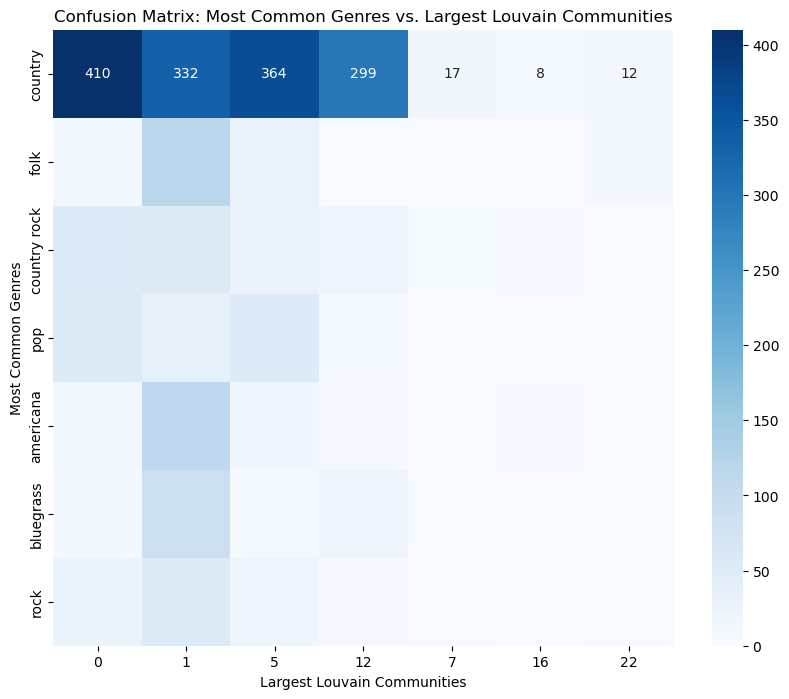

In [12]:
# Convert the partition result into a format of community sizes
louvain_communities = defaultdict(list)
for node, comm_id in partition.items():
    louvain_communities[comm_id].append(node)

# Identify the 7 largest communities by size
community_sizes = {comm_id: len(nodes) for comm_id, nodes in louvain_communities.items()}
largest_communities = sorted(community_sizes, key=community_sizes.get, reverse=True)[:7]

# Map the largest communities to indices
community_to_index = {community: j for j, community in enumerate(largest_communities)}

# Identify the 7 most common genres
all_genres = [genre for genres in genres_data.values() for genre in genres]
most_common_genres = [genre for genre, _ in Counter(all_genres).most_common(7)]

# Map the genres to indices
genre_to_index = {genre: i for i, genre in enumerate(most_common_genres)}

# Build the confusion matrix
D = np.zeros((7, 7))

# Populate the matrix
for node, data in G_genres.nodes(data=True):
    node_genres = genres_data.get(node, [])  # List of genres for the node
    node_community = partition.get(node)  # Louvain community of the node

    # Only consider nodes that match the 7 most common genres and largest communities
    if node_community in largest_communities:
        for genre in node_genres:
            if genre in most_common_genres:
                i = genre_to_index[genre]
                j = community_to_index[node_community]
                D[i, j] += 1

# Convert the matrix to a DataFrame for better readability
D_df = pd.DataFrame(D, index=most_common_genres, columns=largest_communities)
print(D_df)
# Visualize the matrix
plt.figure(figsize=(10, 8))
sns.heatmap(D_df, annot=True, fmt='.0f', cmap='Blues')  
plt.title('Confusion Matrix: Most Common Genres vs. Largest Louvain Communities')
plt.xlabel('Largest Louvain Communities')
plt.ylabel('Most Common Genres')
plt.show()


# Part 3: Words that characterize pages or groups of pages

Now, we'll begin to play around with how far we can get with simple strategies for looking at text. 

The video is basically just me talking about a fun paper, which shows you how little is needed in order to reveal something highly interesting about humans that produce text. But it's important. Don't miss this one!

> **Video lecture**: Simple methods reveal a lot. I talk about the paper: [Personality, Gender, and Age in the Language of Social Media: The Open-Vocabulary Approach](http://journals.plos.org/plosone/article?id=10.1371/journal.pone.0073791).  

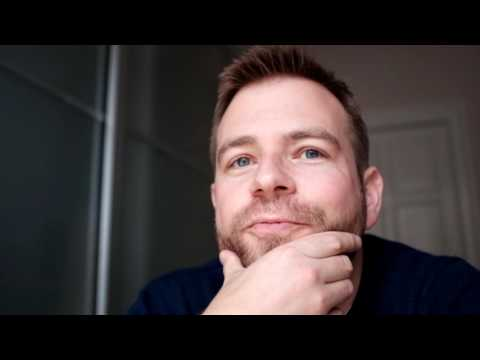

In [13]:
YouTubeVideo("wkYvdfkVmlI",width=800, height=450)

_Exercise_: Comparing in the different genres. 

*Setup*. You'll need to go to your archives and find the wikipedia pages of all the country artists. 

Once you have the texts ready, you will want to aggregate the text into 15 long lists, one for each of the top 15 genres (let's call them 15 *documents*). Each document contains on all the text in that genre (so for the country genre it's a looooong big doc). In each list, you should keep all the words (or *tokens* to be more precise) that occur on the pages, and a count of how frequently each word occurs. So the format should be

```
word0 count0
word1 count1
word2 count2

...

wordN countN
```
This list is called a ***Term Frequency*** (or TF) list for each community. Let's build our own TF lists. Before you start counting, I am going to ask you do do a few things

> *Action items*
> * Tokenize the pages into individual strings
> * Remove all punctuation from your list of tokens
> * Set everything to lower case
> * (Optional) Lemmatize your words
> * It's OK to filter out rare words (e.g. words that only appear less than 5 times).

If you are confused by the instructions for cleaning, go back and have a  look Chapter 3 again. 

> *Action item*: 
> * Create your TF list for each of the 15 most popular genres.
> * List the top 15 words for each genre.
> * Comment on the top 15 words for each genre.

<div class="alert alert-block alert-info">
It's OK to use an LLM to help with the code here, but write your own comments.
</div>

In [14]:
# Function to lemmatize each word based on its part of speech
def lemmatize_word(word):
    lemmatizer = WordNetLemmatizer()
    return lemmatizer.lemmatize(word)

# Function to process the content text
def process_text(content, lemmatize=False):
    # Tokenize the content into individual words
    tokens = word_tokenize(content)
    
    # Remove punctuation and convert to lower case
    tokens = [word.lower() for word in tokens if word.isalpha()]
    
    # Lemmatize the tokens if required
    if lemmatize:
        tokens = [lemmatize_word(word) for word in tokens]
    
    # Filter out rare words that appear less than 5 times
    token_counts = Counter(tokens)
    tokens = [word for word in tokens if token_counts[word] >= 5]
    
    return tokens

# Identify the top 15 genres
top_genres = [genre for genre, _ in Counter(all_genres).most_common(15)]

# Initialize a dictionary to collect processed text content for each top genre
top_text = defaultdict(list)

# Iterate over singers and their genres
for singer, genres in genres_data.items():
        for genre in genres:
            if genre in top_genres:
                file_path = os.path.join(folder_path, singer + ".txt")  # Add .txt extension
                if os.path.exists(file_path):
                    with open(file_path, 'r', encoding='utf-8') as file:
                        content = file.read()
                    
                    # Process the content
                    processed_tokens = process_text(content, lemmatize=True)
                    
                    # Join tokens back into a string and store in top_text
                    processed_content = ' '.join(processed_tokens)
                    top_text[genre].append(processed_content)

# Save top_text data into a JSON file
output_file_path = os.path.join("top_text.json")
with open(output_file_path, 'w', encoding='utf-8') as json_file:
    json.dump(top_text, json_file, ensure_ascii=False, indent=4)

print(f"JSON file saved as {output_file_path}")

JSON file saved as top_text.json


In [15]:
# read the top_text.json file
input_file_path = os.path.join("top_text.json")
with open(input_file_path, 'r', encoding='utf-8') as json_file:
    top_text_per_genre = json.load(json_file)

# create a dictionary to store the TF values for each genre
tf_list_per_genre = {}

for genre, texts in top_text_per_genre.items():
    # Tokenize and preprocess the text
    word_list = []
    for text in texts:
        word_list.extend(word_tokenize(text.lower()))  
    word_list = [word for word in word_list if word.isalpha()]  
    # calculate the frequency of each word
    fdist = FreqDist(word_list)
    
    # calculate the total number of words
    total_words = sum(fdist.values())
    tf_list = {word: freq / total_words for word, freq in fdist.items()}
    tf_list_per_genre[genre] = tf_list

# print the top 15 TF words for each genre
for genre, tf_list in tf_list_per_genre.items():
    print(f"Top 15 TF words for {genre}:")
    sorted_tf = sorted(tf_list.items(), key=lambda x: x[1], reverse=True)[:15]
    for word, tf in sorted_tf:
        print(f"{word}: {tf:.4f}")
    print("\n")

# save the tf_list_per_genre dictionary into a JSON file
output_tf_file_path = os.path.join("tf_list_per_genre.json")
with open(output_tf_file_path, 'w', encoding='utf-8') as json_file:
    json.dump(tf_list_per_genre, json_file, ensure_ascii=False, indent=4)

Top 15 TF words for country:
the: 0.0724
and: 0.0357
of: 0.0350
a: 0.0344
in: 0.0335
ref: 0.0306
to: 0.0211
country: 0.0209
cite: 0.0203
on: 0.0182
album: 0.0164
wa: 0.0144
music: 0.0136
with: 0.0133
for: 0.0123


Top 15 TF words for country rock:
the: 0.0780
and: 0.0361
of: 0.0348
in: 0.0327
a: 0.0324
ref: 0.0288
to: 0.0211
cite: 0.0202
on: 0.0189
album: 0.0186
country: 0.0166
wa: 0.0143
with: 0.0134
for: 0.0122
music: 0.0122


Top 15 TF words for southern rock:
the: 0.0763
and: 0.0370
of: 0.0342
a: 0.0325
ref: 0.0312
in: 0.0301
cite: 0.0206
to: 0.0206
album: 0.0196
on: 0.0186
country: 0.0158
wa: 0.0144
band: 0.0137
with: 0.0124
his: 0.0122


Top 15 TF words for folk:
the: 0.0742
and: 0.0389
of: 0.0366
a: 0.0345
in: 0.0335
ref: 0.0315
cite: 0.0203
to: 0.0202
on: 0.0169
album: 0.0164
wa: 0.0139
with: 0.0135
for: 0.0127
song: 0.0108
music: 0.0107


Top 15 TF words for gospel:
the: 0.0721
of: 0.0367
and: 0.0361
a: 0.0343
in: 0.0328
ref: 0.0243
to: 0.0217
cite: 0.0174
on: 0.0160
wa: 0.014

# Part 4: Visualization

**Step 1: Install the software**

First you must set up your system. The most difficult thing about creating the wordcloud is installing the `WordCloud` module. It's available on GitHub, check out the page [**here**](https://github.com/amueller/word_cloud). 

If you're lucky, you can simply install using conda (and all dependencies, etc will be automatically fixed): 

    conda install -c conda-forge wordcloud
 
If you can't get that to work you can refer here https://anaconda.org/conda-forge/wordcloud. 
Also, maybe the comments below are helpful: 
 * The module depends on the Python library PIL. If my experience generalizes, your life will be easier if you use `conda` to install that before you do anything else.
 * On my system, the module needed the `gcc` compiler installed. If you're not already a programmer, you may have to install that. On Mac you get it by installing the [_command line tools_](http://osxdaily.com/2014/02/12/install-command-line-tools-mac-os-x/). On linux, it's probably already installed. And on Windows I'm not sure, but we'll figure it out during the exercises. 
 * Once that's all set up, you can use `pip` to install the `WordCloud` library, as [detailed on the GitHub page](https://github.com/amueller/word_cloud). But don't forget to use Anaconda's `pip` just as when you installed the communities library a few weeks ago. 
 * There are examples of how to use the module online, see [here](http://sebastianraschka.com/Articles/2014_twitter_wordcloud.html) and [here](https://bioinfoexpert.com/2015/05/26/generating-word-clouds-in-python/). If you're interested, you can read about how the package was put together [here](http://peekaboo-vision.blogspot.dk/2012/11/a-wordcloud-in-python.html). 

**Step 2: Draw some wordclouds**

> *Action items*
> * Get your lists ready for the word-cloud software
>    - The package needs a single string to work on. The way that I converted my lists to a string was to simply combine all words together in one long string (separated by spaces), repeating each word according to its score (rounded up to the nearest integer value). 
>    - The `wordcloud` package looks for collocations in real texts, which is a problem when you make the list as above. The recommended fix is to simply set `collocations = False` as an option when you run the package.
> * Now, create a word-cloud for each genre. Feel free to make it as fancy or non-fancy as you like. Comment on the results. (If you'd like, you can remove stopwords/wiki-syntax - I did a bit of that for my own wordclouds.)

<div class="alert alert-block alert-info">
As above, it's OK to use an LLM to help get the code going. But write your own answers to the questions / write your own comments.
</div>

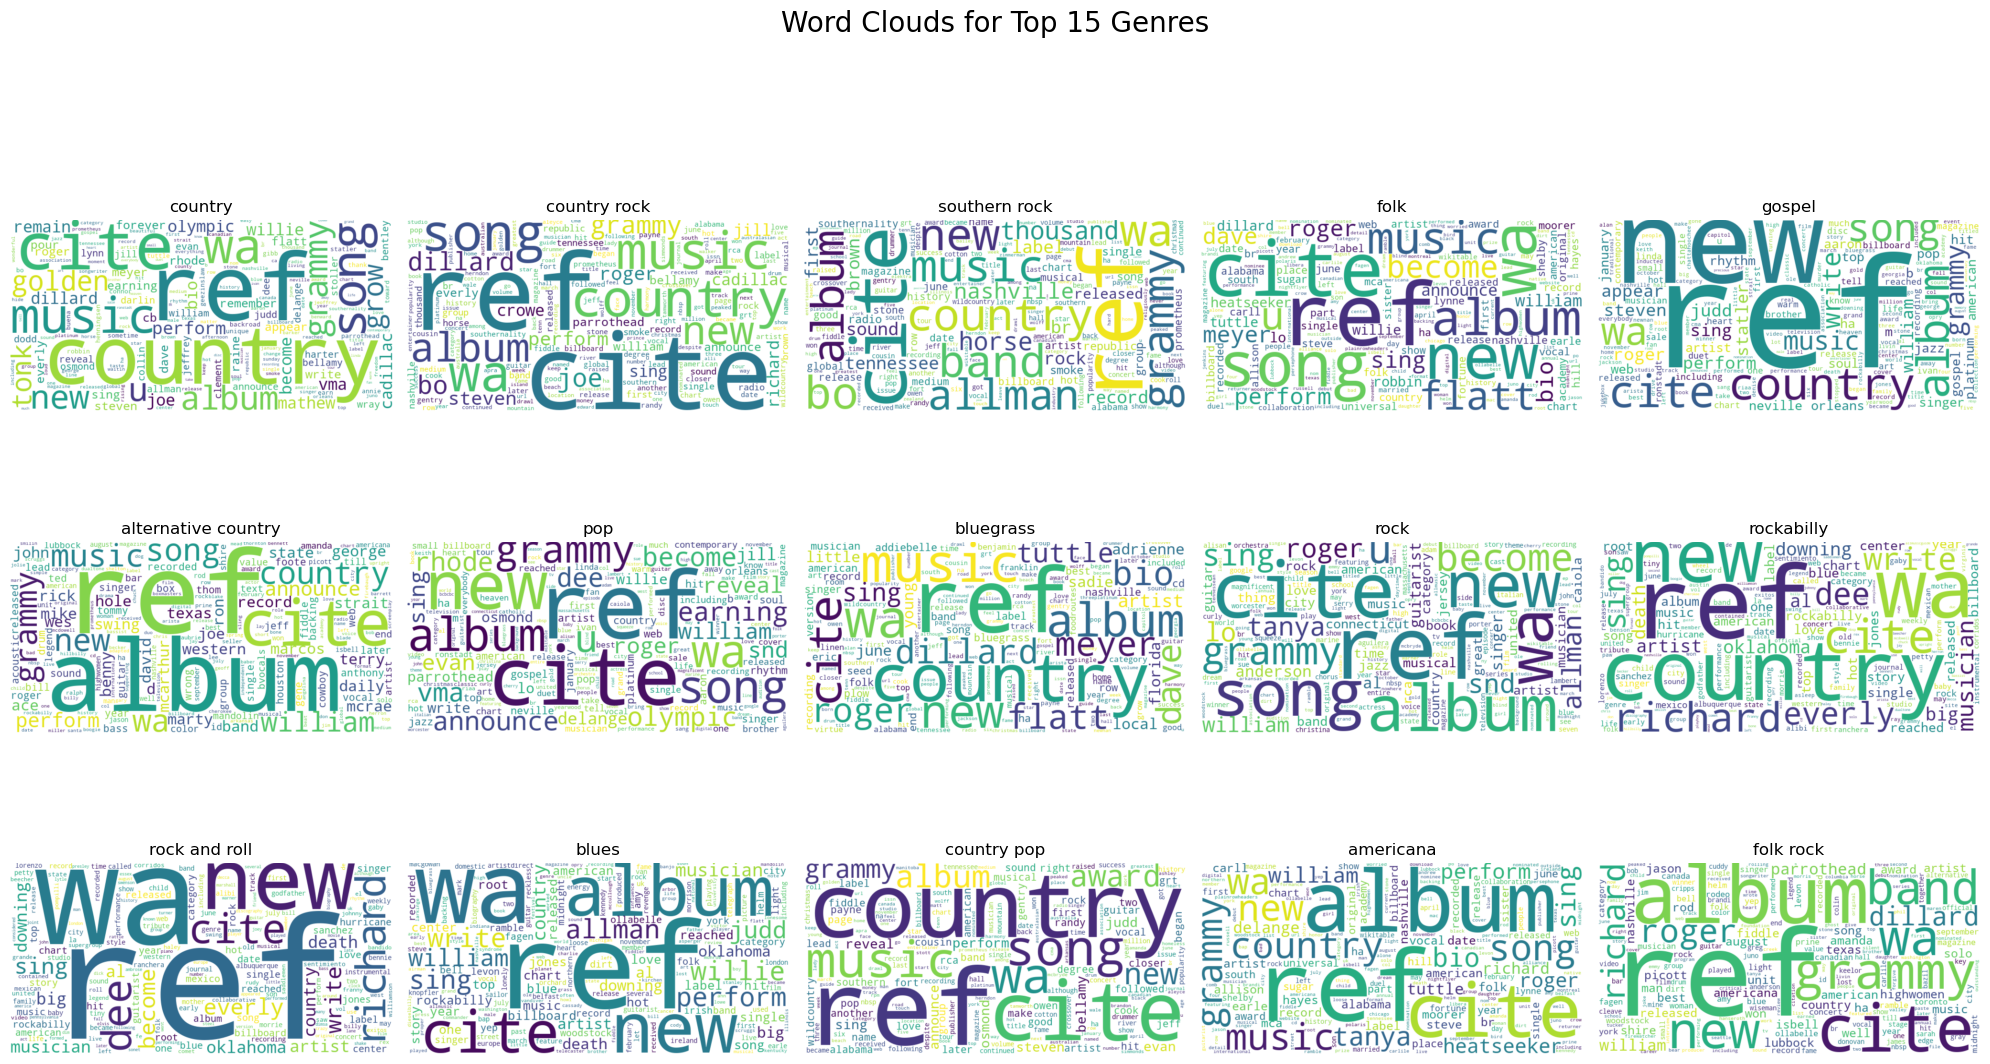

In [16]:
# 读取 JSON 文件
input_file_path = os.path.join("tf_list_per_genre.json")
with open(input_file_path, 'r', encoding='utf-8') as json_file:
    tf_list_per_genre = json.load(json_file)

# 创建用于生成词云的字符串列表
wordcloud_strings = {}

for genre, tf_list in tf_list_per_genre.items():
    # 根据词频，将每个单词重复出现的次数与其 TF 值成比例，四舍五入取整
    words_expanded = []
    for word, tf in tf_list.items():
        repeat_count = math.ceil(tf * 100)  # 放大系数以增加重复次数
        words_expanded.extend([word] * repeat_count)
    
    # 将单词列表连接成单个字符串，用空格分隔
    wordcloud_string = ' '.join(words_expanded)
    wordcloud_strings[genre] = wordcloud_string

# 生成 3x5 子图布局
fig, axes = plt.subplots(3, 5, figsize=(20, 12))
fig.suptitle("Word Clouds for Top 15 Genres", fontsize=20)
axes = axes.flatten()

# 遍历每个流派并绘制词云
for i, (genre, wordcloud_string) in enumerate(wordcloud_strings.items()):
    if i < len(axes):
        wordcloud = WordCloud(width=800, height=400, background_color='white', collocations=False).generate(wordcloud_string)
        axes[i].imshow(wordcloud, interpolation='bilinear')
        axes[i].axis('off')
        axes[i].set_title(genre)

# 移除多余的子图框架
for j in range(i + 1, len(axes)):
    axes[j].axis('off')

plt.tight_layout(rect=[0, 0, 1, 0.95])  # 调整布局
plt.show()


# Part 5: Understanding TF-IDF

Now we jump back into the NLP work. In this last part, we'll be creating word-clouds again. But this time, we'll be using the method from the paper I discuss above: TF-IDF. Historically people have had a hard time grasping the idea behind TF-IDF, so here's a little exercise designed to make you study it a bit more carefully.

*Exercise 4*: Wrap your brain around TF-IDF

First, let's learn about TF-IDF the way wikipedia explains it. Check out [the wikipedia page for TF-IDF](https://en.wikipedia.org/wiki/Tf%E2%80%93idf) and ***read the first part very carefully***. The idea is that the term frequency doesn't capture just what's special about a text. It also captures words that are just frequent in all text. 

This is clear from the top counts in one of my lists:

```
of 
in 
and 
the 
to 
a 
is
by
was
as
ref
with
first
 ```
 
You can fix some of this by removing stop-words (as is described in the book), but it's not enough. ***We want to pull out what's special about a particular text.*** 

To focus on just what's special, TF-IDF has two components: The *term frequency* (TF) and a *weight* (IDF). The weight draws on a larger corpus of text emphasize what's special about the text we're interested in.

Further, there are some extra things going on. For example, there are multiple definitions of TF. Above, we just looked at the raw counts.

> *Action items*
>   * Pick one of the alternative term frequency definitions. Explain why it might sometimes be prefereable to the raw count.
>   * What does IDF stand for? Answer in your own words.
>   * How does IDF draw on a larger corpus to extract what's special a certain text? Answer in your own words.

There are also multiple versions of IDF. Let's think about those for a moment.

> *Action items*
>   * All of the IDF versions take the log of the calculated weight. Why do you think that is?
>   * Explain why using IDF makes stopword removal less important.

<div class="alert alert-block alert-info">
The point of this exercise is to understand TF-IDF. So I encourage you to ask questions to an LLM to really understand the concept. Perhaps ask it to explain TF-IDF at the level of a high-school student. Once you've done that, then answer the questions in the action items on your own.
</div>

# Part 6: Genres and TF-IDF word-clouds

**But wait a minute!** Now we have all of the ingredients for a wonderful cocktail 😎

* We have genres - descriptions of related nodes in the network. 
* And you're an expert on TF-IDF, so you can extract words that characterize a text relative to everything that's going on.
* Finally, you can create nice WordCouds!

So let's put it all together. Let's use TF-IDF and wordcoulds to build a deeper understanding of the top communities.

Thus, the aim of this final part is to create genre wordclouds for the top 15 genres based on TF-IDF. 

For each genre, create a single document for each community consisting of all the cleaned text from all members of the community. So in the end, you should have 15 documents in total.

_Exercise_: Genre Word-clouds

> * Now that we have the community-texts, let's start by grabbing the TF lists from the exercise above (you may modify to use whichever version of TF you like). 
> * Next, calculate IDF for every word in every list (use whichever version of IDF you like). 
>   * Which base logarithm did you use? Is that important?
> * We're now ready to calculate TF-IDFs. Do that for each genre. 
>   * List the 10 top words for each genre accourding to TF-IDF. Are these 10 words more descriptive of the genre than just the TF? Justify your answer.
> * Create a wordcloud for each genre. 
> * Explain your creation. Do the wordclouds/TF-IDF lists enable you to understand the communities you have found (or is it just gibberish)? Justify your answer.

<div class="alert alert-block alert-info">
Overall, it's OK to use an LLM to help with the code. But do write your own answers to the questions.
</div>

In [ ]:
# 1. Prepare community documents: Combine all cleaned text for each genre into a single document
input_file_path = os.path.join("top_text.json")
with open(input_file_path, 'r', encoding='utf-8') as json_file:
    top_text_per_genre = json.load(json_file)

# Create a document for each genre
genres = list(top_text_per_genre.keys())
documents = [' '.join(texts) for texts in top_text_per_genre.values()]

# 2. Compute TF using TfidfVectorizer to get TF values (can set use_idf=False for TF only)
vectorizer_tf = TfidfVectorizer(stop_words='english', use_idf=False, norm=None)
tf_matrix = vectorizer_tf.fit_transform(documents)

# 3. Compute IDF using TfidfVectorizer (use base-10 logarithm)
vectorizer_idf = TfidfVectorizer(stop_words='english', use_idf=True, smooth_idf=True, sublinear_tf=True)
tfidf_matrix = vectorizer_idf.fit_transform(documents)

# 4. Get feature names (words)
feature_names = vectorizer_idf.get_feature_names_out()

# 5. Extract top 10 TF-IDF words for each genre
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), index=genres, columns=feature_names)

# Print the top 10 words for each genre based on TF-IDF
for genre in genres:
    print(f"Top 10 TF-IDF words for {genre}:")
    top_words = tfidf_df.loc[genre].sort_values(ascending=False).head(10)
    for word, score in top_words.items():
        print(f"{word}: {score:.4f}")
    print("\n")

# 6. Create word clouds for each genre
fig, axes = plt.subplots(3, 5, figsize=(20, 12))
fig.suptitle("Word Clouds for Top 15 Genres Based on TF-IDF", fontsize=20)
axes = axes.flatten()

for i, (genre, tfidf_vector) in enumerate(tfidf_df.iterrows()):
    if i < len(axes):
        wordcloud_data = {word: tfidf_vector[word] for word in feature_names if tfidf_vector[word] > 0}
        wordcloud = WordCloud(width=800, height=400, background_color='white', collocations=False).generate_from_frequencies(wordcloud_data)
        axes[i].imshow(wordcloud, interpolation='bilinear')
        axes[i].axis('off')
        axes[i].set_title(genre)

for j in range(i + 1, len(axes)):
    axes[j].axis('off')

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


Top 10 TF-IDF words for country:
wrestling: 0.0278
tillis: 0.0268
autry: 0.0258
eastwood: 0.0255
peck: 0.0248
guyton: 0.0247
match: 0.0246
diffie: 0.0245
oslin: 0.0244
raye: 0.0240


Top 10 TF-IDF words for country rock:
aerosmith: 0.0549
bice: 0.0446
henley: 0.0445
underwood: 0.0437
tweedy: 0.0431
ledoux: 0.0425
worsnop: 0.0423
blundell: 0.0411
yoakam: 0.0407
dire: 0.0407


Top 10 TF-IDF words for southern rock:
bice: 0.0793
skynyrd: 0.0731
fogerty: 0.0693
tritt: 0.0691
lynyrd: 0.0690
jinks: 0.0676
jelly: 0.0665
headhunter: 0.0634
isbell: 0.0632
rossington: 0.0610


Top 10 TF-IDF words for folk:
kit: 0.0467
tallest: 0.0457
connors: 0.0442
ives: 0.0433
rankin: 0.0432
macneil: 0.0427
carnes: 0.0424
zandt: 0.0416
matsson: 0.0406
chapin: 0.0398


Top 10 TF-IDF words for gospel:
laine: 0.0572
mandrell: 0.0513
locklin: 0.0511
underwood: 0.0496
breland: 0.0485
reef: 0.0426
foley: 0.0426
gayle: 0.0422
arnold: 0.0413
pta: 0.0411


Top 10 TF-IDF words for alternative country:
shook: 0.0700
twee

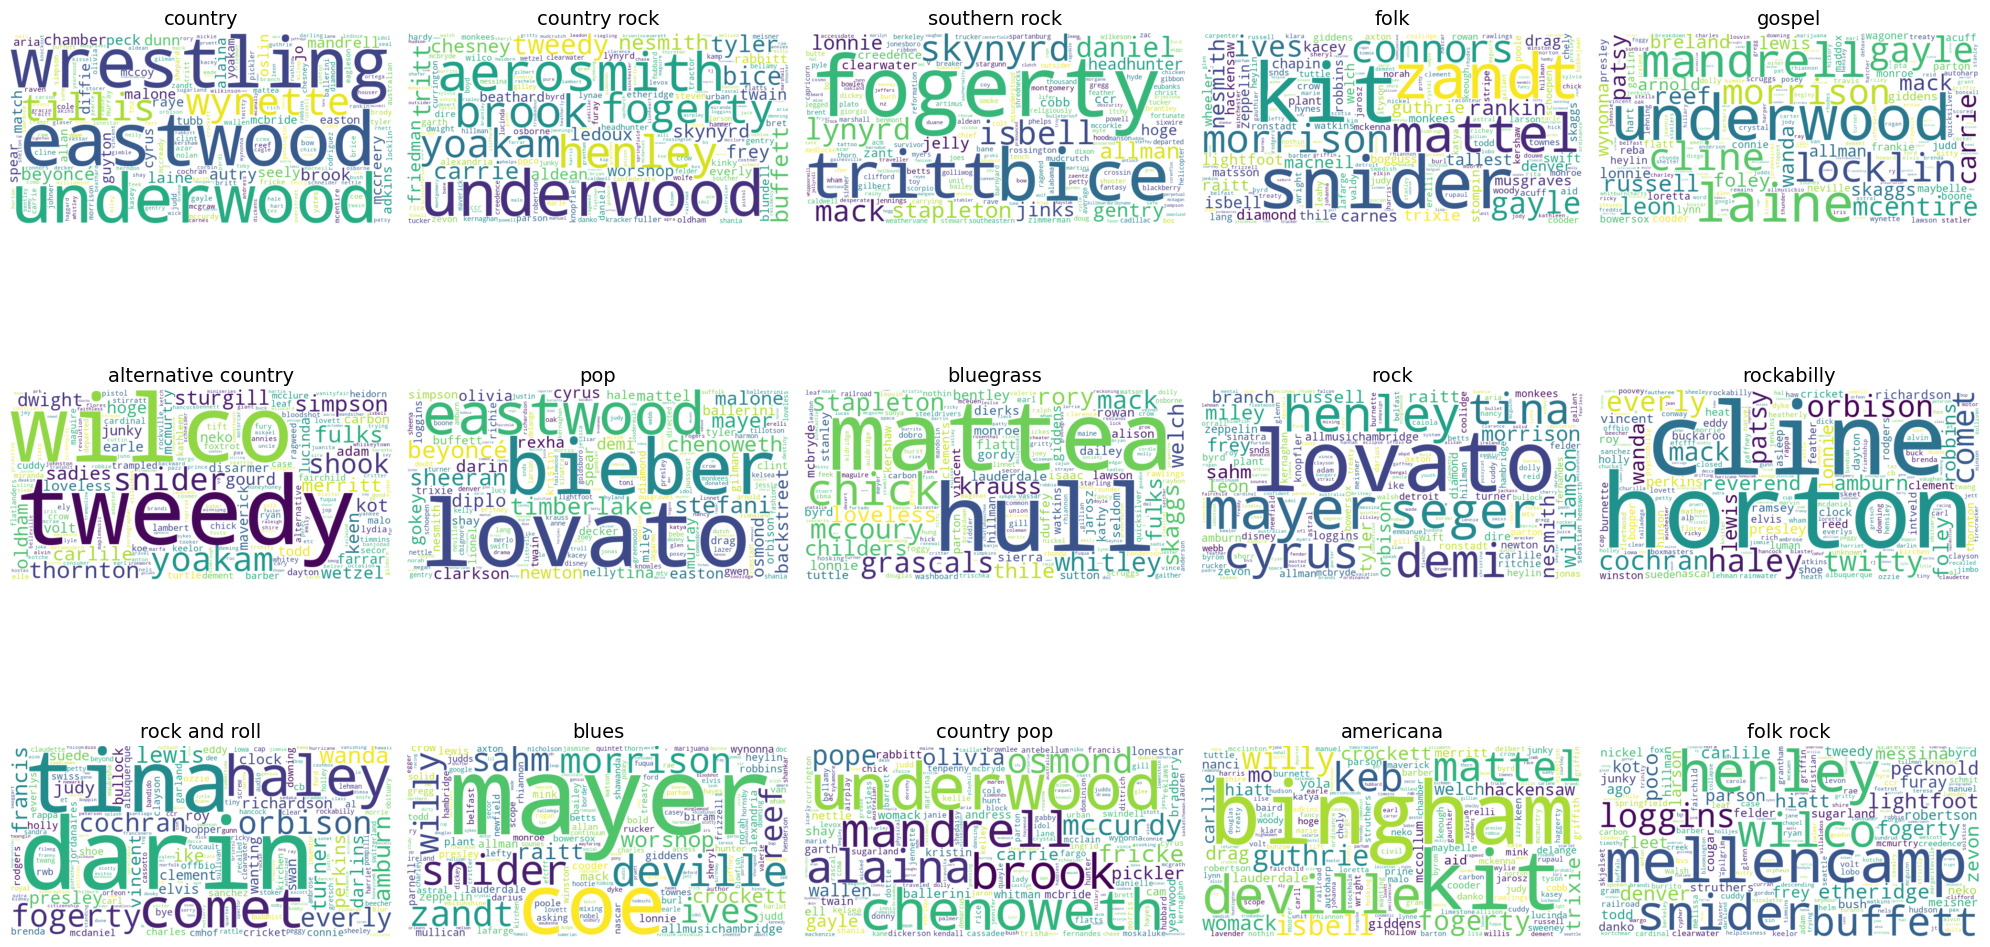

In [18]:

# Load the list of stopwords
stop_words = set(stopwords.words('english'))

# Load the JSON file
with open('tf_list_per_genre.json', 'r') as file:
    data = json.load(file)

# Total number of documents (genres)
N = len(data)

# Count the number of documents (genres) containing each term (n_t)
term_doc_count = {}
for genre, terms in data.items():
    for term in terms:
        if term not in stop_words:  # Exclude stopwords
            if term not in term_doc_count:
                term_doc_count[term] = 0
            term_doc_count[term] += 1

# Calculate the TF-IDF scores
tf_idf_scores = {}
for genre, terms in data.items():
    tf_idf_scores[genre] = {}
    for term, tf in terms.items():
        if term not in stop_words:  # Exclude stopwords
            n_t = term_doc_count.get(term, 0)
            # idf_smooth = math.log(N / (1 + n_t)) + 1
            idf_smooth = (math.log(N / n_t)) ** 1.2
            # idf_smooth = math.log(N / (n_t))
            tf_idf_scores[genre][term] = math.log(1 + tf) * idf_smooth

# Save the TF-IDF scores to a file
with open('tf_idf_scores.json', 'w') as outfile:
    json.dump(tf_idf_scores, outfile, indent=4)

# Plot a 3x5 grid of word clouds for each genre
fig, axes = plt.subplots(3, 5, figsize=(20, 12))
axes = axes.flatten()

for i, (genre, terms) in enumerate(tf_idf_scores.items()):
    if i >= 15:  # Limit to 15 word clouds
        break
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(terms)
    axes[i].imshow(wordcloud, interpolation='bilinear')
    axes[i].set_title(genre, fontsize=14)
    axes[i].axis('off')

plt.tight_layout()
plt.show()

In [19]:
for genre, terms in tf_idf_scores.items():
    sorted_terms = sorted(terms.items(), key=lambda x: x[1], reverse=True)[:10]
    print(f"Top 10 terms for genre '{genre}':")
    for term, score in sorted_terms:
        print(f"  {term}: {score}")
    print("\n")

Top 10 terms for genre 'country':
  eastwood: 0.0005894146285563563
  wrestling: 0.0005764750399114274
  underwood: 0.0005400660087843019
  wynette: 0.000465503152833299
  tillis: 0.0004525683277808526
  beyoncé: 0.00043966007957782873
  brook: 0.0003904792173313883
  autry: 0.0003520029435553981
  mandrell: 0.00033952161303280493
  laine: 0.0003350275533536249


Top 10 terms for genre 'country rock':
  underwood: 0.0025388467911180777
  aerosmith: 0.001706762239434049
  brook: 0.0012288861225854156
  henley: 0.0012203695337788148
  fogerty: 0.001098757922134384
  yoakam: 0.001011091094901704
  tweedy: 0.00098439660010465
  bice: 0.0008024451503310598
  tritt: 0.0008010029577654722
  carrie: 0.0007331127291022367


Top 10 terms for genre 'southern rock':
  fogerty: 0.004272941545378316
  bice: 0.003123480321194757
  tritt: 0.0029472939550923877
  skynyrd: 0.0028932264742172822
  isbell: 0.002336084455297311
  lynyrd: 0.0020726561757282514
  mack: 0.00200996297585167
  daniel: 0.0018292

*Exercise*: Community Word-clouds
> * Redo the exercise above but for the structural communities.
> * Do the word clouds seem more meaningful than for the genres? Add nuance to your answer by considering the confusion matrix $D$ that you calculated above.

<div class="alert alert-block alert-info">
Since this is optional, you can do wat you want with LLMs. Maybe you can get one to solve the whole exercise?
</div>